In [3]:
import os, sys
import numpy as np
from astropy import units, constants
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model
import lmfit
import matplotlib.cm as cm
import matplotlib.animation as animation
from lightkurve.lightcurve import LightCurve


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
plt.rcParams['font.size']=18

def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'interp_between_1.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced2')

_, flare_orbits, flare_mask = np.load('/Users/belugawhale/Documents/AUMic/flare_mask2.npy',
                                      allow_pickle=True)

parula = np.load('/Users/belugawhale/parula_colors.npy')

distance = (9.72*units.pc).to(units.cm)


COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

In [4]:
fwc = FlaresWithCOS(wavelength=np.append(w20, w30, axis=0), 
                    flux=np.append(f20, f30, axis=0),
                    flux_err=np.append(e20, e30, axis=0), 
                    time=np.append(t20, t30)-t20[0], 
                    orbit=np.append(o20, o30+5))
fwc.load_line_table(path='/Users/belugawhale/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/belugawhale/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

main_ions = ['CII_10', 'SiIII', 'CIII', 'NV_1', 'NV_2', 'FeXXI']
ion_color = parula[np.linspace(0,200,5,dtype=int)]
quies_color = '#878482'

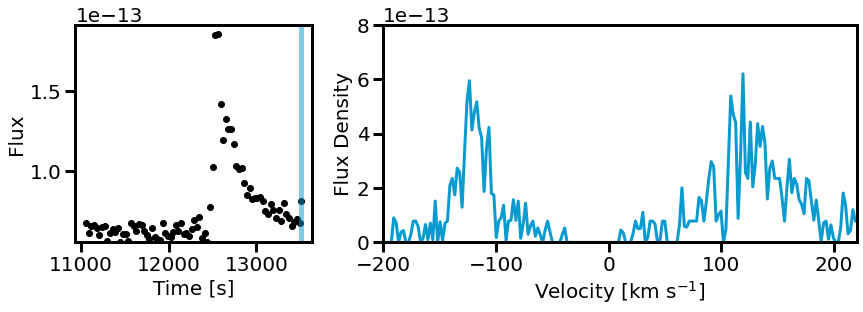

In [138]:
orbit2 = np.where(fwc.orbit==2)[0]
x = 0

fig, (ax1, ax2) = plt.subplots(ncols=2, 
                               figsize=(14,4), 
                               gridspec_kw={'width_ratios':[1,2]})
fig.set_facecolor('w')

def update(i):
    x = i+2
    u = orbit2[i]
    
    ax1.clear()
    ax2.clear()
    
    ax1.plot(fwc.time[orbit2], fwc.width_table['CII_10'][orbit2], 
             'ko', zorder=0)
    ax1.vlines(fwc.time[u].value, 0, 1,
             color=parula[x], lw=5, alpha=0.5)
    
    v,_ = fwc.to_velocity(fwc.wavelength[u], 
                        mid=1335.1)
    q = ((v.value>-200) &
         (v.value<220))
    test[i] = np.nansum(fwc.flux[u][q])
    ax2.plot(v[q], fwc.flux[u][q], c=parula[x], lw=3)
    
    ax1.set_ylim(np.nanmin(fwc.width_table['CII_10'][orbit2]),
                 np.nanmax(fwc.width_table['CII_10'][orbit2])*1.03)
    ax2.set_xlim(-200,220)
    ax2.set_ylim(0, 8e-13)
    ax2.set_xlabel('Velocity [km s$^{-1}$]')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Flux')
    ax2.set_ylabel('Flux Density')

ani = animation.FuncAnimation(fig, update, frames=len(orbit2),
                              interval=200)
ani.save('/Users/arcticfox/Desktop/test.mp4')

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_13805/1797663986.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Desktop/flareB_CII_tail.png', dpi=200, rasterize=True,


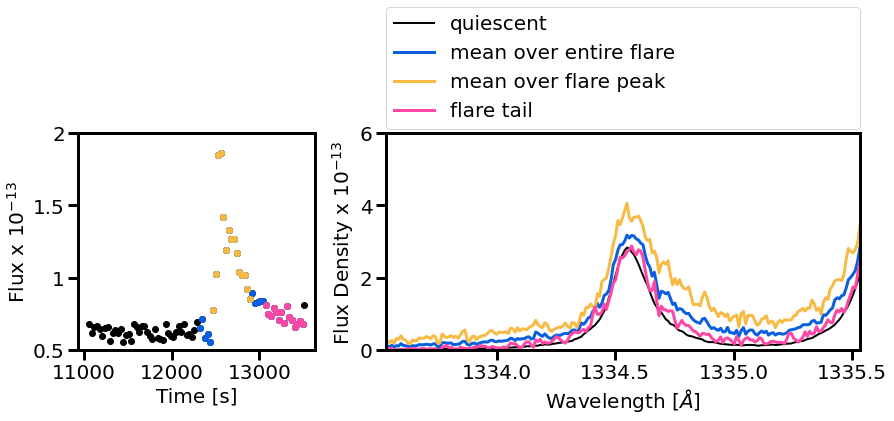

In [148]:
fig, (ax1, ax2) = plt.subplots(ncols=2, 
                               figsize=(14,4), 
                               gridspec_kw={'width_ratios':[1,2]})
fig.set_facecolor('w')

quiesc = np.nansum(flare_mask,axis=0)==0

ax1.plot(fwc.time[orbit2], fwc.width_table['CII_10'][orbit2], 
         'ko', zorder=0)
ax1.plot(fwc.time[flare_mask[1]>0], 
         fwc.width_table['CII_10'][flare_mask[1]>0], 
         parula[30],marker='o', linestyle='')
ax1.plot(fwc.time[flare_mask[1]>0][5:20], 
         fwc.width_table['CII_10'][flare_mask[1]>0][5:20], 
         parula[210],marker='o', linestyle='')
ax1.plot(fwc.time[flare_mask[1]>0][25:], 
         fwc.width_table['CII_10'][flare_mask[1]>0][25:], 
         'xkcd:barbie pink',marker='o', linestyle='')

ax2.plot(fwc.wavelength[0],
         np.nanmean(fwc.flux[quiesc], axis=0), 'k', lw=2,
         label='quiescent')

ax2.plot(fwc.wavelength[0],
         np.nanmean(fwc.flux[flare_mask[1]>0], axis=0), parula[30],
         lw=3,
         label='mean over entire flare')
ax2.plot(fwc.wavelength[0],
         np.nanmean(fwc.flux[flare_mask[1]>0][5:20], axis=0),
         parula[210], lw=3,
         label='mean over flare peak')
ax2.plot(fwc.wavelength[0],
         np.nanmean(fwc.flux[flare_mask[1]>0][25:], axis=0),
         'xkcd:barbie pink', lw=3,
         label='flare tail')

ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
#plt.yscale('log')
ax2.set_xlim(fwc.line_table[fwc.line_table['ion']=='CII_10']['wave_c']-1,
             fwc.line_table[fwc.line_table['ion']=='CII_10']['wave_c']+1)
ax2.set_xlabel('Wavelength [$\AA$]')
ax2.set_ylabel('Flux Density x 10$^{-13}$')
ax1.set_ylabel('Flux x 10$^{-13}$')
ax1.set_xlabel('Time [s]')

ax2.set_ylim(0,6e-13)
ax2.set_yticks([0,2e-13,4e-13,6e-13])
ax2.set_yticklabels([0, 2, 4, 6])

ax1.set_ylim(0.5e-13,2e-13)
ax1.set_yticks([0.5e-13,1e-13,1.5e-13,2e-13])
ax1.set_yticklabels([0.5,1,1.5,2])
plt.savefig('/Users/arcticfox/Desktop/flareB_CII_tail.png', dpi=200, rasterize=True,
            bbox_inches='tight')

In [109]:
fwc.line_table[fwc.line_table['ion']=='CII_10']['wave_c']

1334.532


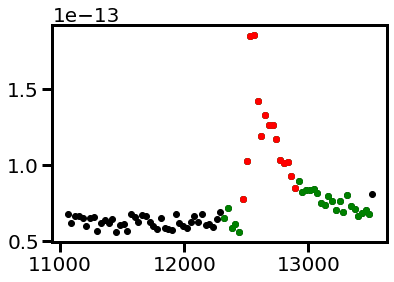

In [94]:
plt.plot(fwc.time[orbit2], fwc.width_table['CII_10'][orbit2], 'ko', zorder=0)
plt.plot(fwc.time[flare_mask[1]>0], 
         fwc.width_table['CII_10'][flare_mask[1]>0], 'go')
plt.plot(fwc.time[flare_mask[1]>0][5:20], 
         fwc.width_table['CII_10'][flare_mask[1]>0][5:20], 'ro')

In [6]:
fwc.measure_ew(ion='CII_10')

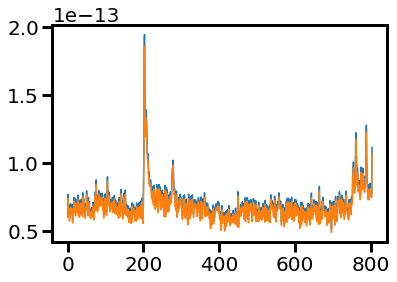

In [22]:
plt.plot(test/1e2)
plt.plot(fwc.width_table['CII_10'])


## Line fitting

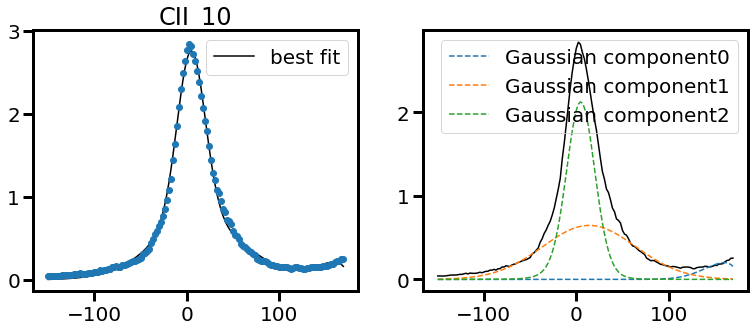

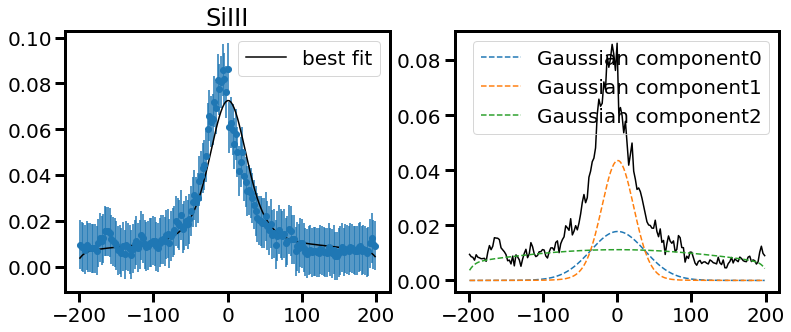

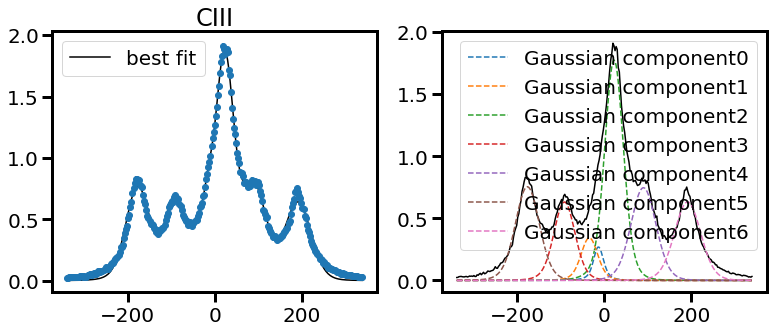

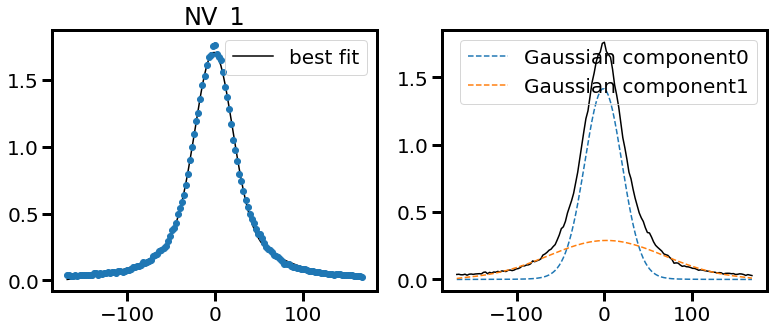

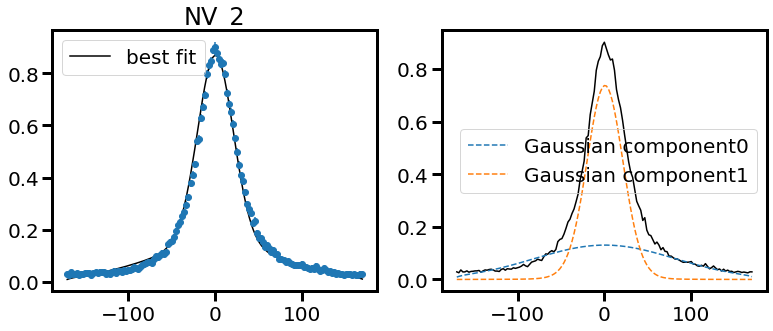

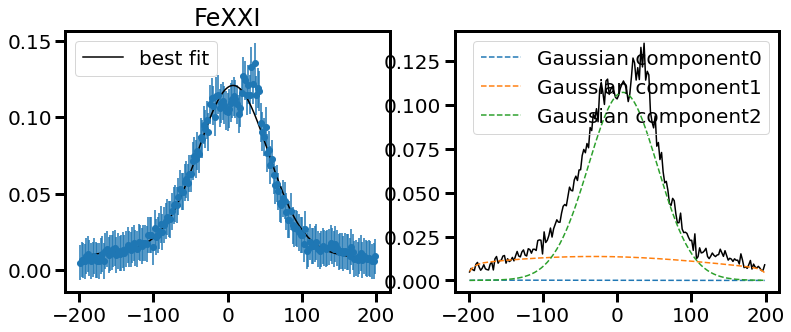

In [5]:
oot = np.nansum(flare_mask, axis=0)==0
scaling = 1e-13

oof_values = []

for i in range(len(main_ions)):
    ngauss = fwc.line_table[fwc.line_table['ion']==main_ions[i]]['ngauss'].data[0]+0
    
    if i == 0:
        ngauss = 3
    #elif i == 1:
    #    ngauss = 3
    elif i == 2:
        ngauss = 7
    elif i == 5 or i==1:
        ngauss = 3
    else:
        ngauss=2

    spect = np.nanmean(fwc.flux[oot],axis=0)
    err = np.sqrt(np.nansum(fwc.flux_err[oot]**2,axis=0))/(len(fwc.flux[oot]))*0.5
    
    
    x,y,yerr,w,lsf,out = fwc.model_line_shape(ion=main_ions[i],
                                              mask=oot, 
                                              ngauss=ngauss, 
                                              ext=100,
                                              f=spect/scaling, 
                                              ferr=err/scaling)
    args = [x,y,yerr,w,lsf,out.minimize(max_nfev=3000), out]
    oof_values.append(args)
    
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    
    axes[0].errorbar(x, y, yerr=yerr, marker='o', linestyle='')

    axes[0].plot(args[0], args[-1].best_fit, 'k-', label='best fit')
    axes[0].legend(loc='best')
    axes[0].set_title(main_ions[i])
    comps = args[-1].eval_components(x=args[0])
    
    axes[1].plot(args[0], args[1], 'k')
    for i in range(ngauss):
        axes[1].plot(args[0], 
                     comps['g{}_'.format(i)], '--', label='Gaussian component'+str(i))
    axes[1].legend(loc='best')
    plt.show()

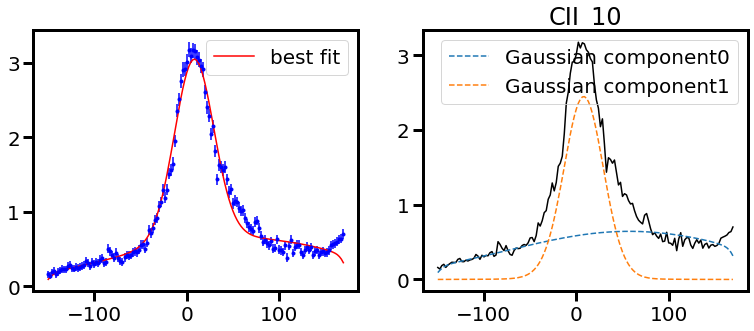

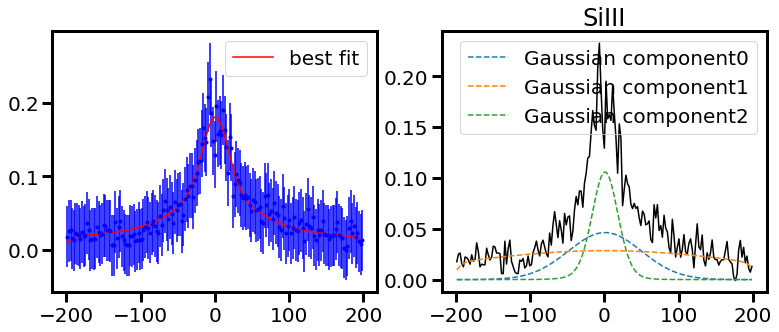

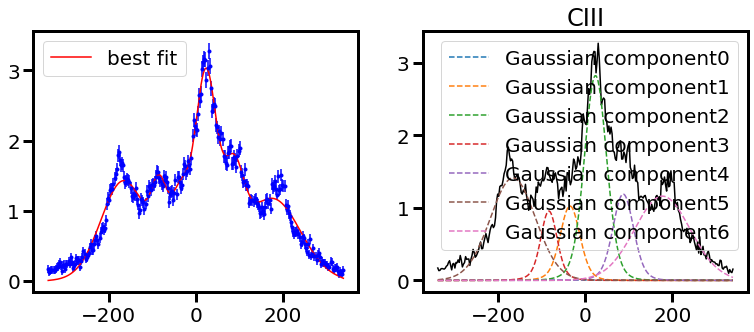

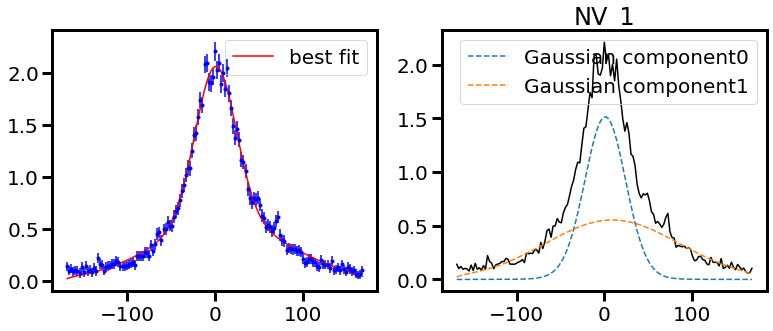

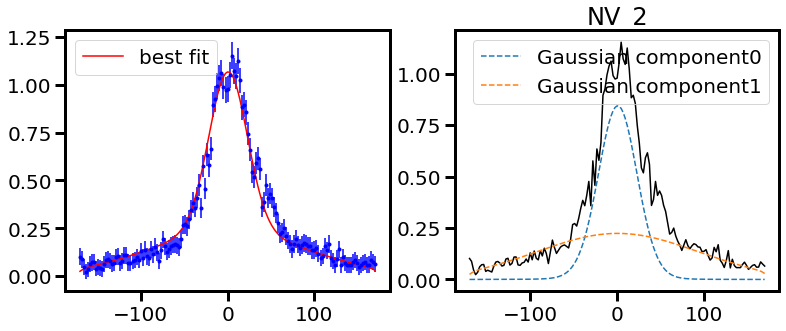

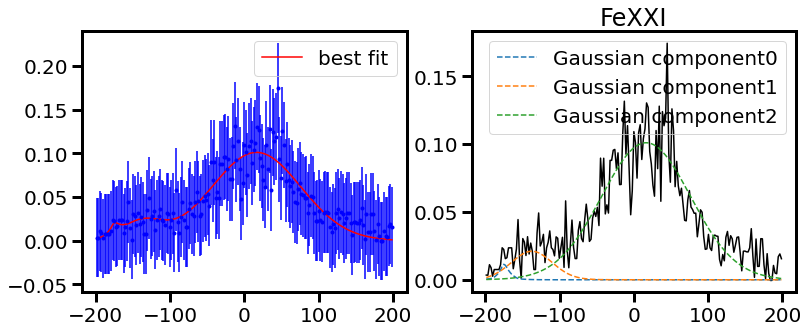

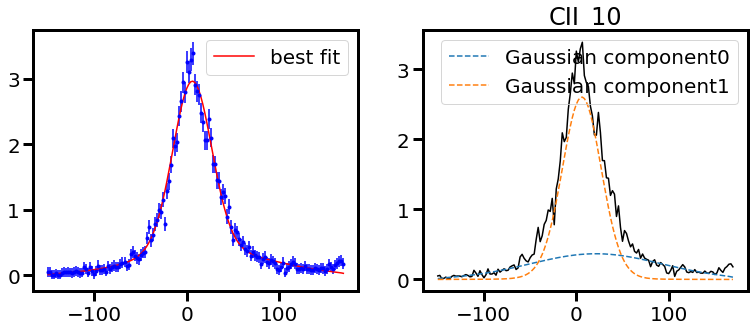

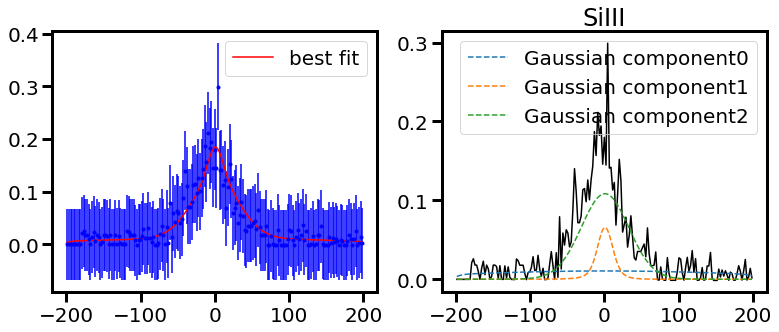

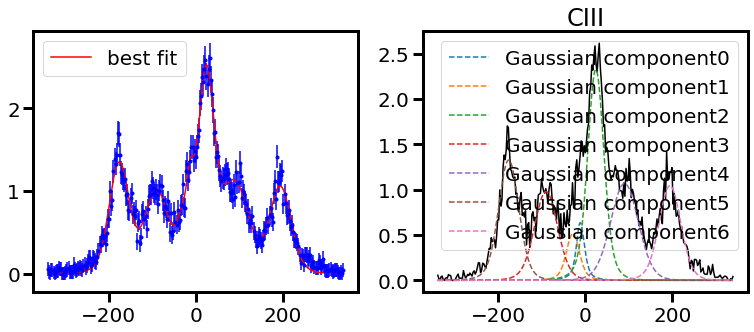

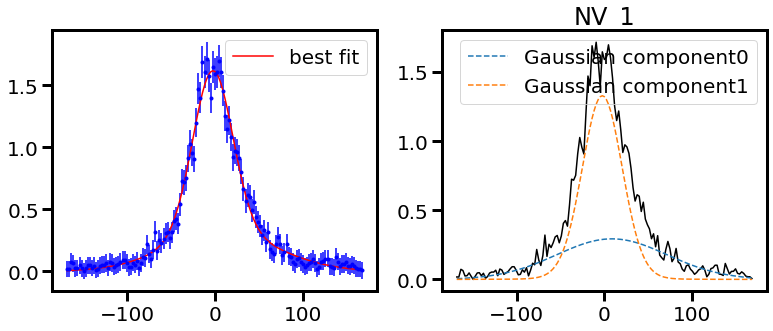

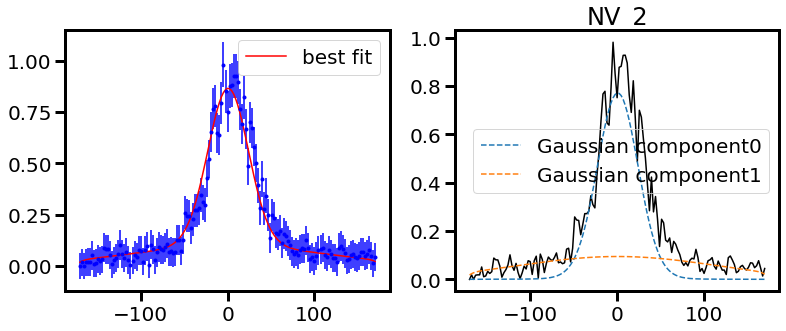

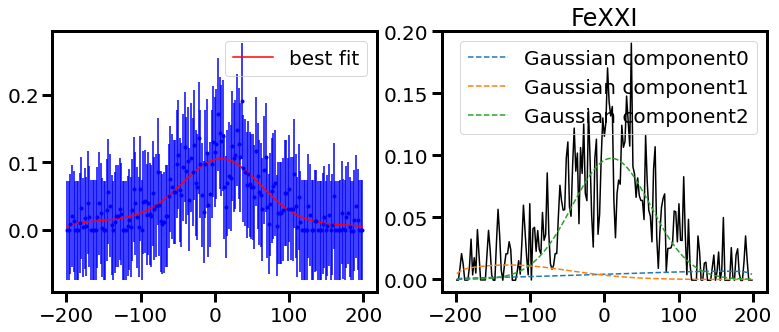

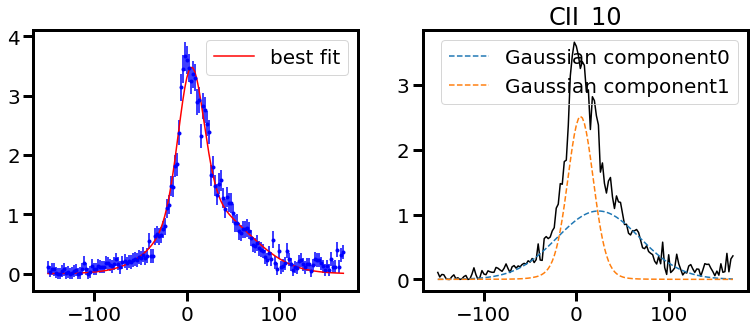

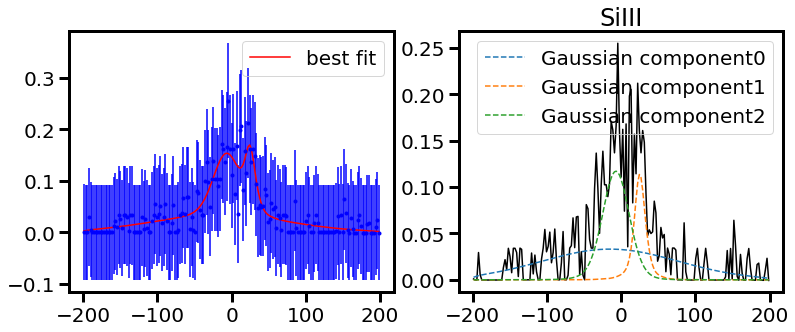

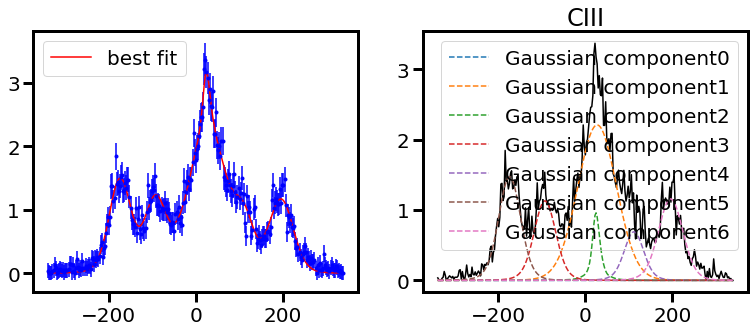

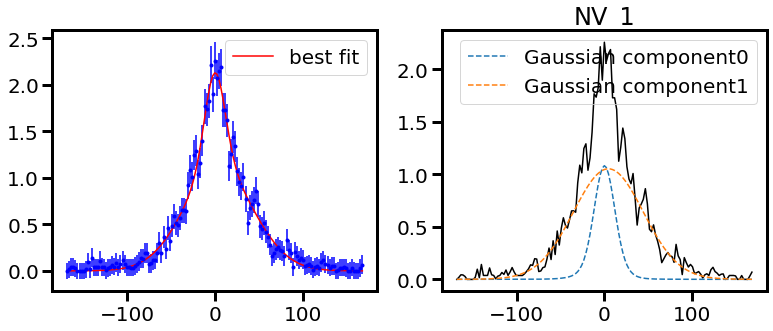

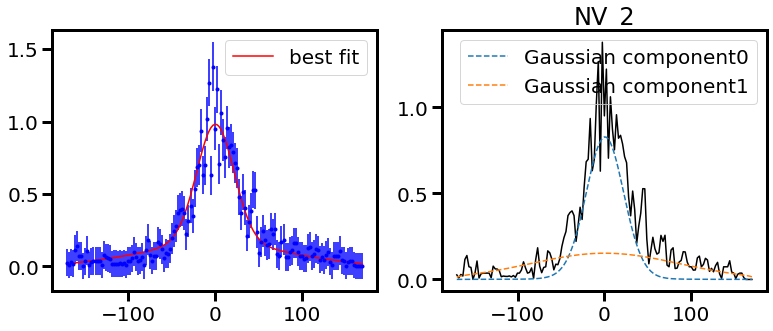

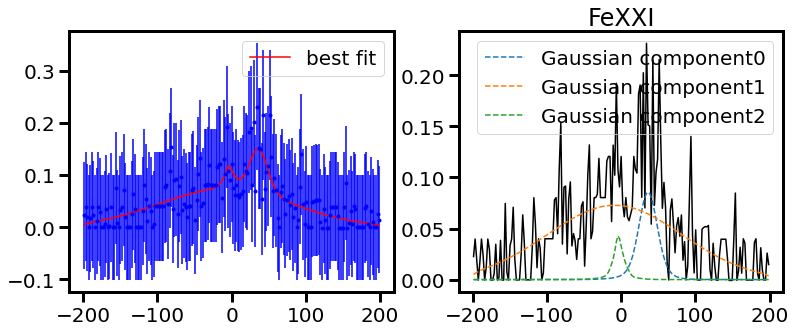

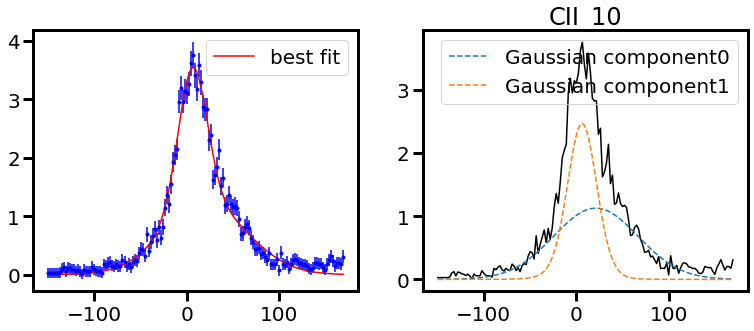

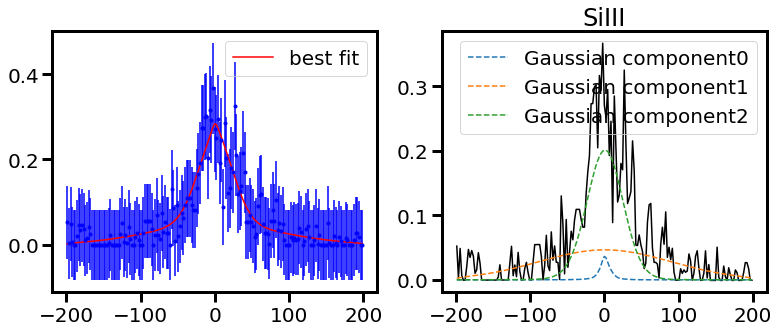

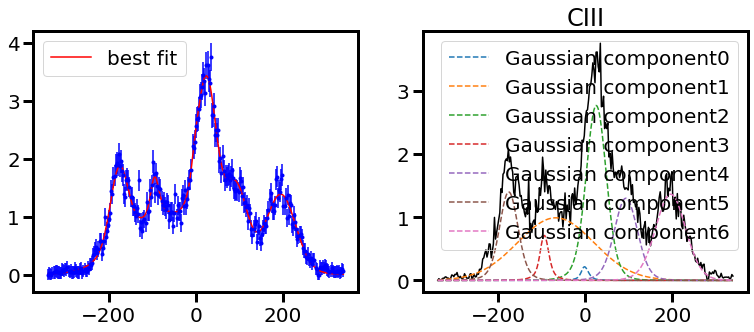

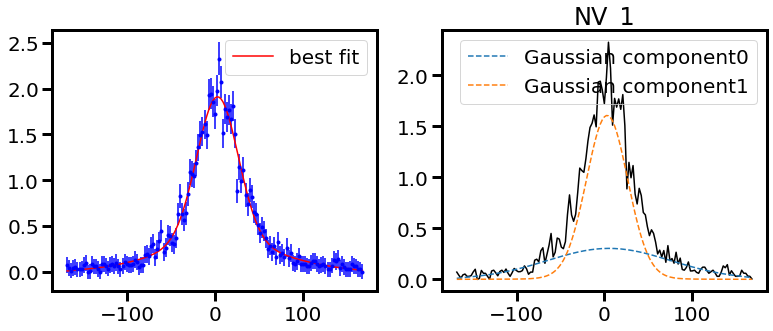

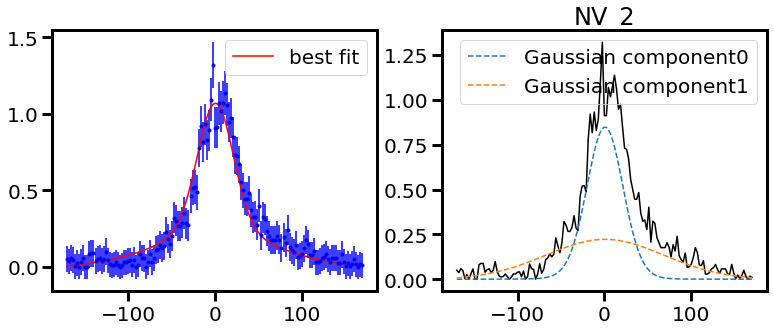

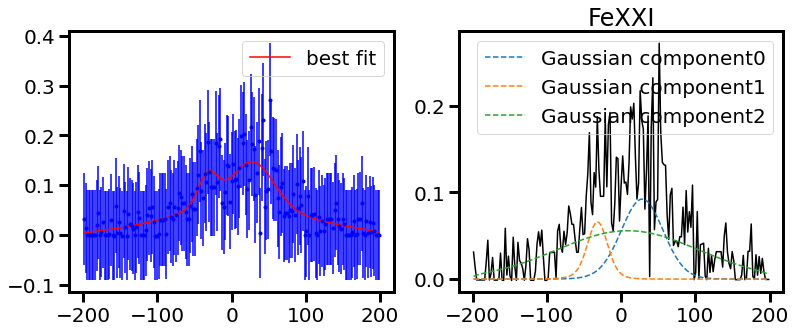

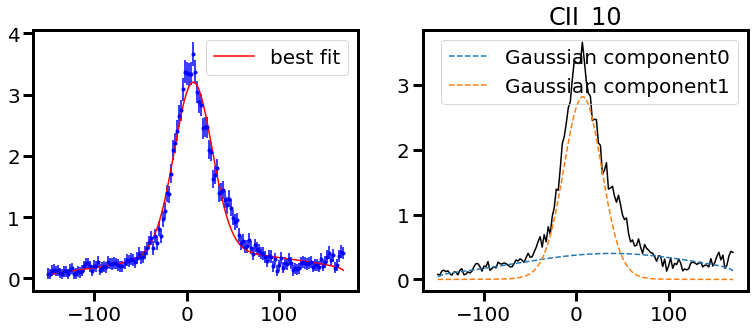

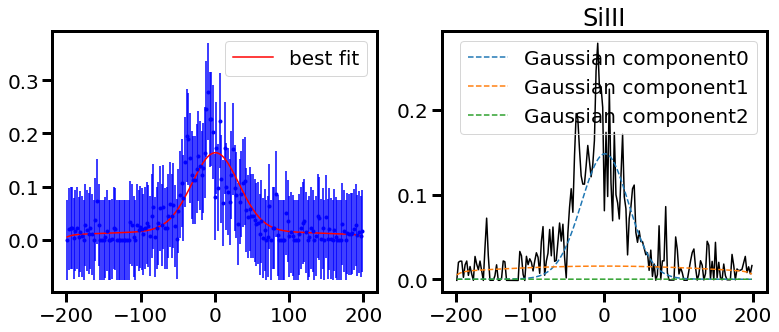

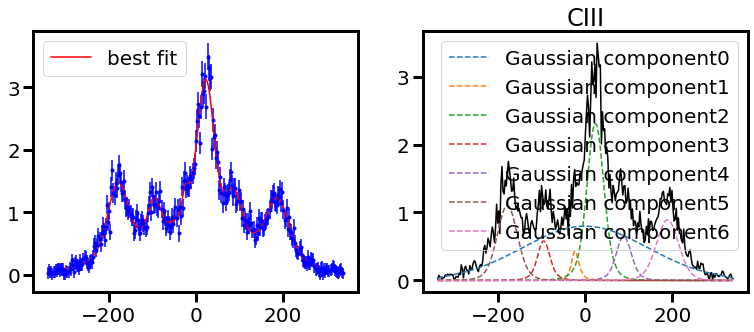

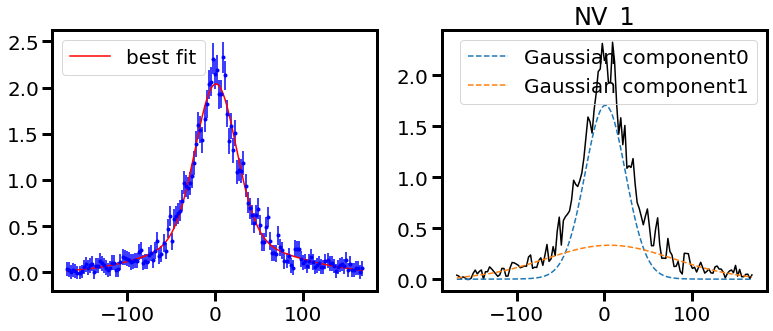

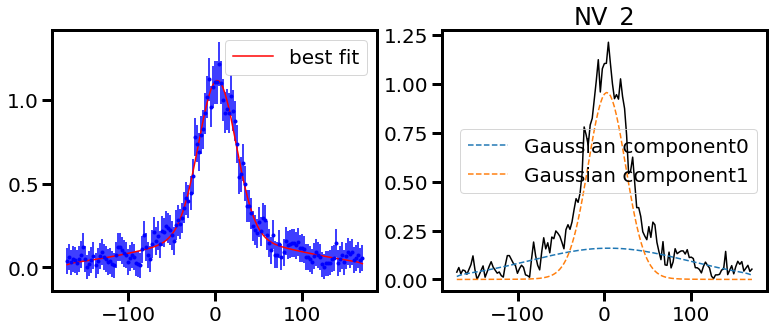

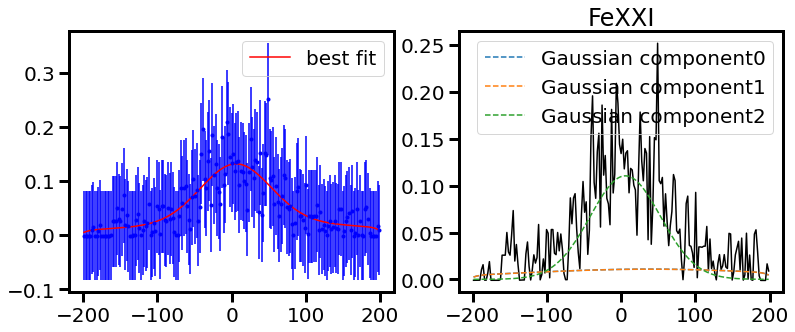

In [6]:
ngauss=4

it_masks = [flare_mask[1]>0,
            flare_mask[3]>0,
            flare_mask[-4]>0,
            flare_mask[-3]>0,
            flare_mask[-1]>0]

if_values = []

main_ions = ['CII_10', 'SiIII', 'CIII', 'NV_1', 'NV_2', 'FeXXI']

for m in it_masks:
    temp = []
    for i in range(len(main_ions)):
        ngauss = fwc.line_table[fwc.line_table['ion']==main_ions[i]]['ngauss'].data[0]+0

        if i == 2:
            ngauss = 7
        elif i == 5 or i==1:
            ngauss = 3
        else:
            ngauss=2
            
        spect = np.nanmean(fwc.flux[m],axis=0)
        err = np.sqrt(np.nansum(fwc.flux_err[m]**2,axis=0))/(len(fwc.flux[m]))*0.5
    
        x,y,yerr,w,lsf,out = fwc.model_line_shape(ion=main_ions[i],
                                                  mask=m, 
                                                  ngauss=ngauss, 
                                                  ext=100,
                                                  f=spect/scaling, 
                                                  ferr=err/scaling)
        args = [x,y,yerr,w,lsf,out.minimize(max_nfev=3000), out]

        fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
        axes = axes.reshape(-1)
        axes[0].errorbar(args[0], args[1], yerr=args[2], color='b',
                         linestyle='', marker='.')
        #axes[0].plot(vel, init, 'k--', label='initial fit')
        axes[0].plot(args[0], args[-1].best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')

        comps = args[-1].eval_components(x=args[0])
        axes[1].plot(args[0], args[1], 'k')
        for n in range(ngauss):
            axes[1].plot(args[0], comps['g{}_'.format(n)], '--', label='Gaussian component'+str(n))
        axes[1].legend(loc='best')
        axes[1].set_title(main_ions[i])
        plt.show()
        temp.append(args)
    if_values.append(temp)

In [7]:
oof_models = []

for i in range(len(oof_values)):
    res = oof_values[i][-1].minimize(max_nfev=10000, xtol=1e-8)
    oof_models.append(res)
    
if_models = []
for j in range(len(if_values)):
    temp = []
    for i in range(len(if_values[j])):
        res = if_values[j][i][-1].minimize(max_nfev=20000,xtol=1e-8)
        temp.append(res)
    if_models.append(temp)

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_73890/2944886488.py:95: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/belugawhale/Documents/AUMic/paper/linewidths.pdf',


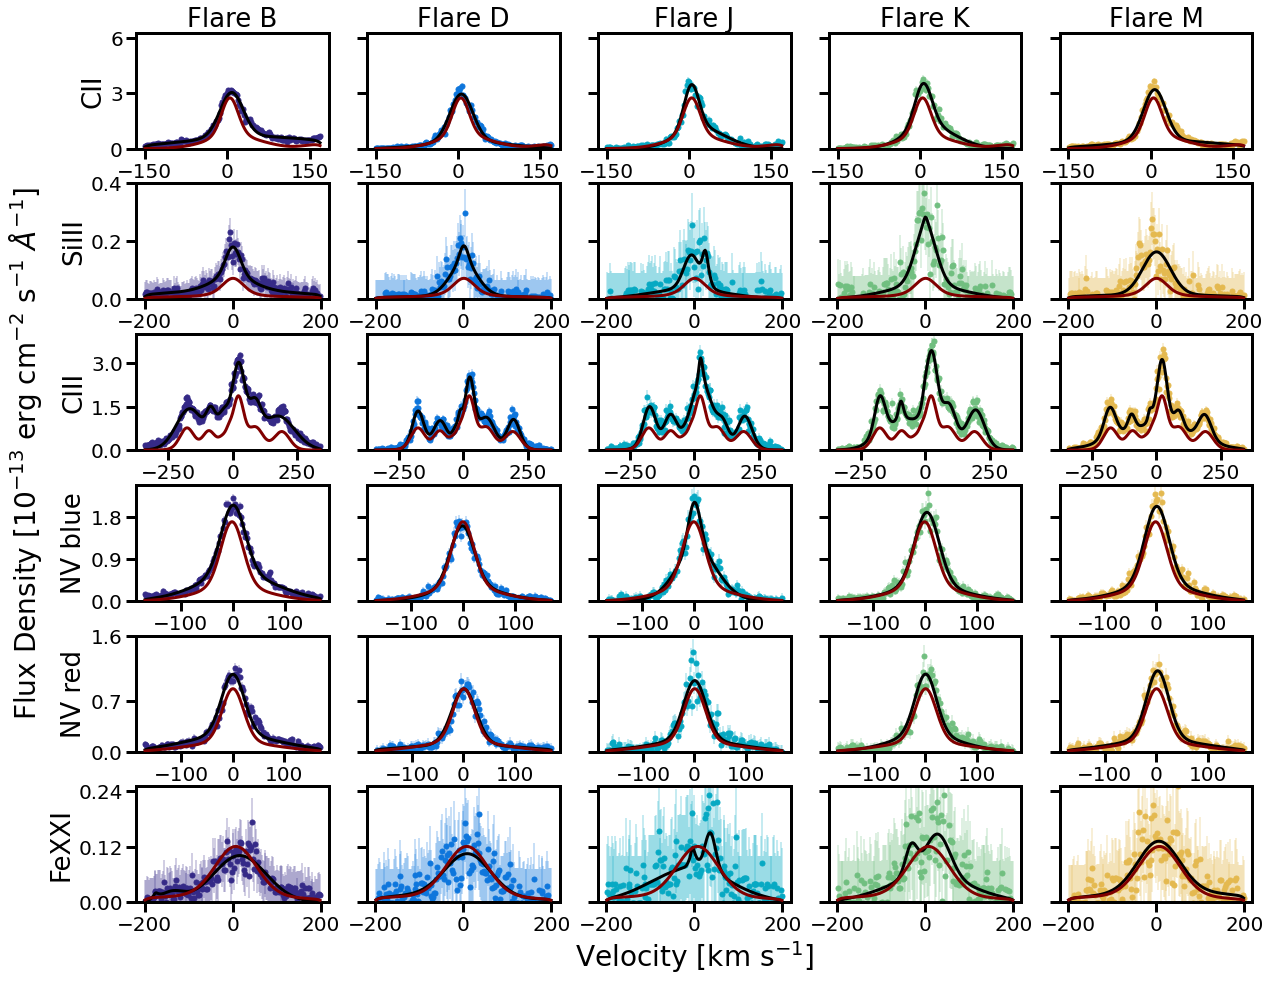

In [9]:
fig, axes = plt.subplots(ncols=5, nrows=6, figsize=(20,16))
fig.set_facecolor('w')
lw = 3
i = 0
ions = ['CII', 'SiIII', 'CIII', 'NV blue', 'NV red', 'FeXXI']
fontsize=26

ax = axes.reshape(-1)
ax_ints = np.arange(0,30,5,dtype=int)
f1 = ax[ax_ints]#:5]
f2 = ax[ax_ints+1]#4:9]
f3 = ax[ax_ints+2]#8:12]
f4 = ax[ax_ints+3]#12:]
f5 = ax[ax_ints+4]

fs = [f1,f2,f3,f4,f5]

for j in range(len(fs)):
    for i in range(len(ions)):
        
        fs[j][i].errorbar(if_values[j][i][0], if_values[j][i][1], 
                          color=ion_color[j], alpha=0.3,
                          ms=1, marker='.', zorder=1,
                          yerr=if_values[j][i][2], linestyle='')
        fs[j][i].errorbar(if_values[j][i][0], if_values[j][i][1], 
                          color=ion_color[j], 
                          ms=10, marker='.', zorder=1,
                          linestyle='')


        oo = build_lmfit(oof_values[i][0], 
                         params=oof_values[i][-2].params,
                         lsf=oof_values[i][4], std=-5)
        fs[j][i].plot(oof_values[i][0], oof_values[i][-1].best_fit,
                      color='maroon',lw=3,
                      zorder=3)
            
        fs[j][i].plot(if_values[j][i][0], if_values[j][i][-1].best_fit, color='k', lw=3)
            

        try:
            up = build_lmfit(if_values[j][i][0], 
                                 params=if_models[j][i].params,
                                 lsf=if_values[j][i][4], std=2)
            lo = build_lmfit(if_values[j][i][0], 
                                 params=if_models[j][i].params,
                                 lsf=if_values[j][i][4], std=-1)

        except:
            pass
            
        if j > 0:
            fs[j][i].set_yticklabels([])
        
        if j == 0:# and i ==2:
            fs[j][i].set_ylabel('{}'.format(ions[i]), fontsize=fontsize)
            
        if j == 0 and i == 2:
            str1 = 'Flux Density [10$^{-13}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'
            fs[j][i].text(s=str1, rotation=90, x=-875, y=-9, fontsize=fontsize+2)
            
        if i == 5 and j == 2:
            fs[j][i].set_xlabel('Velocity [km s$^{-1}$]', fontsize=fontsize+2)
        
        fs[j][i].set_rasterized(True)
        
        if i == 0:
            fs[j][i].set_ylim(0,6.3)
            fs[j][i].set_yticks([0,3,6])
        elif i == 1:
            fs[j][i].set_ylim(0,0.4)
            fs[j][i].set_yticks([0,0.2,0.4])
        elif i == 2:
            fs[j][i].set_ylim(0,4)
            fs[j][i].set_yticks([0,1.5,3])
        elif i == 3:
            fs[j][i].set_ylim(0,2.5)
            fs[j][i].set_yticks([0,0.9, 1.8])
        elif i == 4:
            fs[j][i].set_ylim(0,1.5)
            fs[j][i].set_yticks([0,0.7,1.6])
        else:
            fs[j][i].set_ylim(0,0.25)
            fs[j][i].set_yticks([0,0.12,0.24])
            
        if i == 0:
            fs[j][i].set_xticks([-150,0,150])
            
f1[0].set_title('Flare B', fontsize=fontsize)
f2[0].set_title('Flare D', fontsize=fontsize)
f3[0].set_title('Flare J', fontsize=fontsize)
f4[0].set_title('Flare K', fontsize=fontsize)
f5[0].set_title('Flare M', fontsize=fontsize)
plt.subplots_adjust(hspace=0.3);
plt.savefig('/Users/belugawhale/Documents/AUMic/paper/linewidths.pdf',
            dpi=250, rasterize=True, bbox_inches='tight')